<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_QuantumEspressoColab_Basic_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Quantum espresso calculations with JARVIS-Tools

In [1]:
!pip install jarvis-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 42.7 MB/s eta 0:00:00


In [2]:
%%time
import os
# Clone the QE git
if not os.path.exists('q-e'):
   os.system('git clone https://github.com/QEF/q-e.git')
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
%cd q-e
# run the configure file
!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp
! make pw

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
The following NEW packages will be installed:
  libfftw3-3 libfftw3-bin libfftw3-dev libfftw3-doc libfftw3-long3
  libfftw3-quad3 libfftw3-single3
0 upgraded, 7 newly installed, 0 to remove and 46 not upgraded.
Need to get 4,251 kB of archives.
After this operation, 23.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu1 [313 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-single3 amd64 3.3.8-2ubuntu1 [756 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfftw3-3 amd64 3.3.8-2ubuntu1 [1,760 B]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu1 [673 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-bin

In [ ]:
#!make ph

In [5]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2200.214
BogoMIPS:                        4400.42
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

In [7]:
from jarvis.core.atoms import Atoms
from jarvis.db.figshare import data
import numpy as np
import pandas as pd

dft_3d = data('dft_3d')
df=pd.DataFrame(dft_3d)
#Filter based on elements
def has_elements(atoms_dict = {}, my_element = ['Al','O']):
    atoms = Atoms.from_dict(atoms_dict)
    elements = atoms.elements
    if set(my_element)==set(elements):
        return True
    else:
        return np.nan

df['el'] = df['atoms'].apply(lambda x: has_elements(atoms_dict = x, my_element = ['Si']))
df1 = df.dropna()
df_eform_filter = df1[df1['formation_energy_peratom']==0]
df_eform_filter



Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,poisson,raw_files,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,el
25912,JVASP-24792,227,Fd-3m,Si,0.0,OptB88vdW,0.731,"{'lattice_mat': [[3.3641546699579417, -2.54062...",33.23,0.0,...,na,"[DFPT,JVASP-24792.zip,https://ndownloader.figs...",2,na,na,1.277,na,mp-149,-Si,True
42489,JVASP-1002,227,Fd-3m,Si,-0.0,OptB88vdW,0.731,"{'lattice_mat': [[3.3641499856336465, -2.50271...",33.23,0.0,...,0.21,"[FD-ELAST,JVASP-1002.zip,https://ndownloader.f...",2,87.27,63.28,1.277,1.22,mp-149,-Si,True


In [8]:
#Lets select JVASP-1002
from jarvis.db.figshare import get_jid_data
from jarvis.tasks.qe.super import SuperCond
from jarvis.core.utils import get_factors
from jarvis.core.atoms import Atoms
from jarvis.db.figshare import data, get_jid_data
from jarvis.core.kpoints import Kpoints3D
from jarvis.tasks.queue_jobs import Queue
from jarvis.db.jsonutils import dumpjson
import os
from jarvis.analysis.structure.spacegroup import Spacegroup3D
import glob
from jarvis.db.jsonutils import loadjson

jid = 'JVASP-1002' #Silicon
dat = get_jid_data(jid=jid, dataset="dft_3d")

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [9]:
qe_cmd = "/content/q-e/bin/pw.x"
a_atoms = Atoms.from_dict(dat["atoms"])
atoms = Spacegroup3D(a_atoms).refined_atoms.get_primitive_atoms
kp = Kpoints3D().automatic_length_mesh(lattice_mat=atoms.lattice_mat, length=dat["kpoint_length_unit"])
kpts = kp._kpoints[0]
print ('kpts',kpts)


kpts [11, 11, 11]


In [10]:
from jarvis.tasks.qe.qe import QEjob
relax = {
            "control": {
                # "calculation": "'scf'",
                "calculation":  "'vc-relax'",
                "restart_mode": "'from_scratch'",
                "prefix": "'RELAX'",
                "outdir": "'./'",
                "tstress": ".true.",
                "tprnfor": ".true.",
                "disk_io": "'nowf'",
                "wf_collect": ".true.",
                "pseudo_dir": None,
                "verbosity": "'high'",
                "nstep": 100,
            },
            "system": {
                "ibrav": 0,
                "nat": None,
                "ntyp": None,
                "ecutwfc": 45,
                "ecutrho": 250,
                "q2sigma": 1,
                "ecfixed": 44.5,
                "qcutz": 800,
                "occupations": "'smearing'",
                "degauss": 0.01,
                "lda_plus_u": ".false.",
            },
            "electrons": {
                "diagonalization": "'david'",
                "mixing_mode": "'local-TF'",
                "mixing_beta": 0.3,
                "conv_thr": "1d-9",
            },
            "ions": {"ion_dynamics": "'bfgs'"},
            "cell": {"cell_dynamics": "'bfgs'", "cell_dofree": "'all'"},
        }
qejob_relax = QEjob(
    atoms=a_atoms,
    input_params=relax,
    output_file="relax.out",
    qe_cmd=qe_cmd,
    jobname="relax",
    kpoints=kp,
    input_file="arelax.in",
    url=None,
    psp_dir=None,
    psp_temp_name=None,
)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053


In [11]:
%%time
info = qejob_relax.runjob()

Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/q-e/RELAX.save/data-file-schema.xml
CPU times: user 2.3 s, sys: 273 ms, total: 2.57 s
Wall time: 7min 38s


In [12]:
!ls

archive		 dft-d3			KCW	    PHonon	   std.err
arelax.in	 Doc			KS_Solvers  PP		   TDDFPT
atomic		 environment_variables	LAXlib	    pseudo	   test-suite
bin		 EPW			License     PW		   upflib
cmake		 external		logo.jpg    PWCOND	   UtilXlib
CMakeLists.txt	 FFTXlib		LR_Modules  QEHeat	   XClib
configure	 GUI			Makefile    README_GPU.md  XSpectra
CONTRIBUTING.md  GWW			make.inc    README.md
COUPLE		 HP			MBD	    relax.json
CPV		 include		Modules     relax.out
dev-tools	 install		NEB	    RELAX.save


In [13]:
info

{'out_path': '/content/q-e/relax.out',
 'xml_path_': 'na',
 'total_energy': -260.14064640715867,
 'job_done': True,
 'xml_path': '/content/q-e/RELAX.save/data-file-schema.xml'}

In [14]:
from jarvis.io.qe.outputs import DataFileSchema
ds = DataFileSchema('/content/q-e/RELAX.save/data-file-schema.xml')

In [15]:
print(ds.final_energy) #Hartree, QE usually reports data in Ha

-9.559993249944725


In [16]:
print(ds.final_energy_breakdown) #eV

{'etot': -260.1406464056546, 'eband': 8.43745558494172, 'ehart': 14.900605434130384, 'vtxc': -90.79550456760238, 'etxc': -116.00515742493373, 'ewald': -228.46781489837625, 'demet': -2.198274517421642e-05}


In [17]:
print(ds.final_structure)

Si2
1.0
3.326542426344914 -8.687857022623688e-10 1.9205801644522624
1.1088474746292054 3.1362944762735903 1.9205801644522624
6.312949592895172e-18 5.790257300394911e-18 3.8411603289045257
Si
2
Cartesian
3.880966163142504 2.7442576154190497 6.722030575582919
0.5544237378316195 0.39203685998575666 0.9602900822261315



In [18]:
print(ds.indir_gap)

0.4883906213979321


In [19]:
print(ds.nelec)

8


In [20]:
print(ds.efermi)

6.36874195429499


In [21]:
import numpy as np
%matplotlib inline
hartree_to_ev = 27.2113839

def dos(data, smearing=0.2):
    """Density of states."""
    """Based on sum of gaussians with smearing as given"""

    #TODO: make work nicely for spin-polarized case, with minority spins plotted negative.

    nkpts = data.nkpts
    eigvals = []
    kweight = []
    for i in range(nkpts):
        eig = np.array(
            data.data["qes:espresso"]["output"]["band_structure"][
                "ks_energies"
            ][i]["eigenvalues"]["#text"].split(),
            dtype="float",
        )
        eigvals.append(eig)
        kweight.append(float(data.data["qes:espresso"]["output"]["band_structure"]["ks_energies"][i]["k_point"]["@weight"]))


    efermi = data.efermi
    eigvals = np.array(eigvals) * hartree_to_ev - efermi
    kweight = np.array(kweight)


    minval = np.min(np.array(eigvals))
    maxval = np.max(np.array(eigvals))



    energies = np.arange(minval-0.5, maxval+0.5, 0.01)
    de = 0.01
    norm = (1/2.0/np.pi/smearing**2)**0.5
    DOS = np.zeros(np.shape(energies)[0])

    for k in range(nkpts):
        for e in eigvals[k,:]:
            DOS += kweight[k] *norm * np.exp( -0.5*(energies - e)**2 / smearing**2)
    return energies, DOS

energies, DOS = dos(ds)

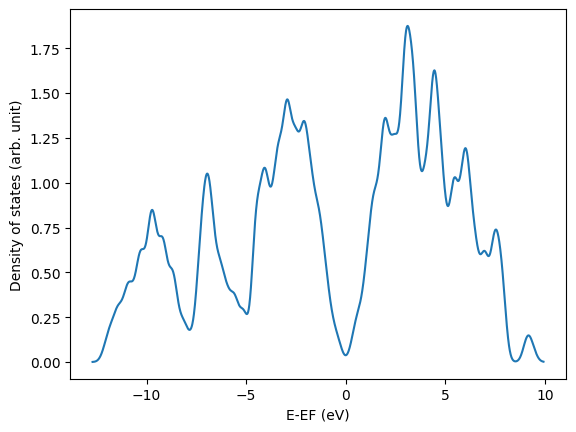

In [24]:
import matplotlib.pyplot as plt
plt.plot(energies, DOS)
plt.xlabel('E-EF (eV)')
plt.ylabel('Density of states (arb. unit)')
plt.show()

In [ ]:
#Other data available in xml file
import pprint
pprint.pprint(ds.data)

Streaming output truncated to the last 5000 lines.
                                                                                          '3.555352731062077E-01   '
                                                                                          '4.173112583550452E-01   '
                                                                                          '4.354861317379202E-01',
                                                                                 '@size': '8'},
                                                                 'k_point': {'#text': '4.379080664274246E-01   '
                                                                                      '1.032159158340963E-01  '
                                                                                      '-2.528263402437891E-01',
                                                                             '@weight': '4.6296296296296545E-003'},
                                                   